In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
transformation = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [5]:
train_data = datasets.ImageFolder(r"S:\Pneumonia classification project\Pneumonia classification project\chest_xray\train", transform=transformation)
test_data = datasets.ImageFolder(r"S:\Pneumonia classification project\Pneumonia classification project\chest_xray\test", transform=transformation)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

train_data.classes

['NORMAL', 'PNEUMONIA']

In [6]:
train_labels = train_data.targets
test_labels = test_data.targets
lbl_train = {"Normal": train_labels.count(0), "Pneumonia": train_labels.count(1)}
lbl_test = {"Normal": test_labels.count(0), "Pneumonia": test_labels.count(1)}

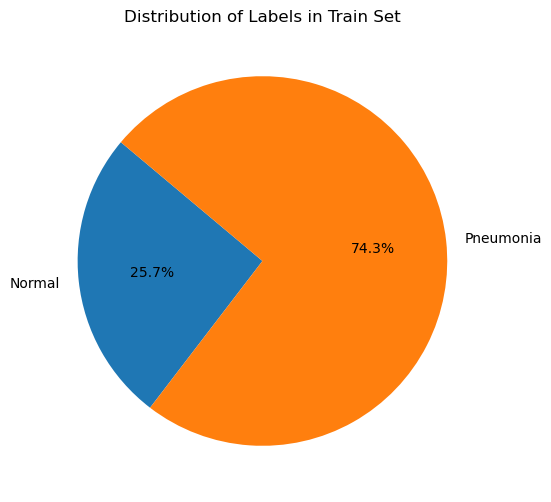

In [7]:
plt.figure(figsize=(6, 6))
plt.pie(lbl_train.values(), labels=lbl_train.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels in Train Set')
plt.show()

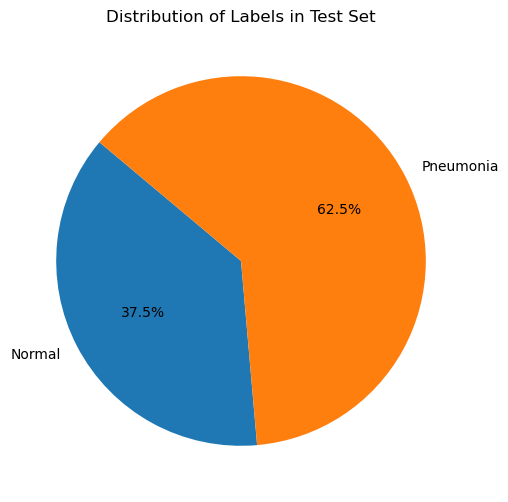

In [8]:
plt.figure(figsize=(6, 6))
plt.pie(lbl_test.values(), labels=lbl_test.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels in Test Set')
plt.show()

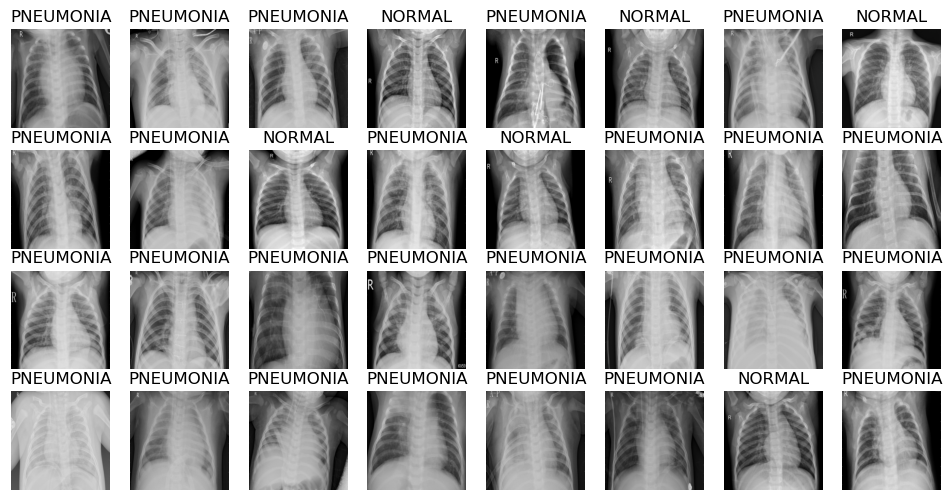

In [9]:
plt.figure(figsize=(12, 6))  
inverse = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

for img,labels in train_loader: 
    break 
for i in range(len(img)//2):
    plt.subplot(4, 8, i + 1)
    image = inverse(img[i])
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.title(train_data.classes[labels[i]])
    plt.axis(False)

In [10]:
def pneumoniaClassifierCNN():
    model = models.resnet50(pretrained = True)
    model.fc = nn.Linear(model.fc.in_features,2)
    return model

In [11]:
model = pneumoniaClassifierCNN().to(device)

S:\conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
S:\conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:
epochs = 5
for epoch in range(epochs):
    print(f'{epoch+1} of {epochs} epochs:')
    train_loss = 0
    for batch, (img, label) in enumerate(train_loader):
        
        img, label = img.to(device), label.to(device)
        
        preds = model(img) 
        loss = criterion(preds, label)
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    print(f"Train loss: {train_loss:.5f}")

1 of 5 epochs:
Train loss: 0.53457
2 of 5 epochs:
Train loss: 0.19652
3 of 5 epochs:
Train loss: 0.19841
4 of 5 epochs:
Train loss: 0.13179
5 of 5 epochs:
Train loss: 0.11873


In [23]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

def precision_fn(y_true, y_pred):
    true_positives = torch.logical_and(torch.eq(y_true, 1), torch.eq(y_pred, 1)).sum().item()
    predicted_positives = torch.eq(y_pred, 1).sum().item()
    precision = true_positives / predicted_positives
    return precision

def recall_fn(y_true, y_pred):
    true_positives = torch.logical_and(torch.eq(y_true, 1), torch.eq(y_pred, 1)).sum().item()
    label_positives = torch.eq(y_true, 1).sum().item()
    recall = true_positives / label_positives
    return recall

def f1_score_fn(y_true, y_pred):
    precision = precision_fn(y_true, y_pred)
    recall = recall_fn(y_true, y_pred)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [24]:
loss, accuracy, recall, precision, f1 = 0, 0, 0, 0, 0
model.eval()
with torch.inference_mode():
    for img, label in test_loader:
        
        img, label = img.to(device), label.to(device)
        preds = model(img)

        loss += criterion(preds, label)
        
        accuracy += accuracy_fn(label, preds.argmax(dim=1))
        recall += recall_fn(label, preds.argmax(dim=1))
        precision += precision_fn(label, preds.argmax(dim=1))
        f1 += f1_score_fn(label, preds.argmax(dim=1))

    loss /= len(test_loader)
    accuracy /= len(test_loader)
    recall /= len(test_loader)
    precision/= len(test_loader)
    f1 /= len(test_loader)

print(f"Loss: {loss:.5f},\n Accuracy: {accuracy:.2f},\n Recall: {recall:.2f},\n Precision: {precision:.2f},\n F1: {f1:.2f}\n")

Loss: 0.44193,
 Accuracy: 0.83,
 Recall: 0.93,
 Precision: 0.83,
 F1: 0.87

